## Initializing SparkSession

In [485]:
# Import PySpark
import pyspark

# Import modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import numpy as np
import matplotlib.pyplot as plt

# Create sparksession and giving an app name
spark = SparkSession \
        .builder \
        .appName("paynet") \
        .getOrCreate()

## Read JSON file

In [486]:
# Read JSON file into a PySpark DataFrame
df = spark.read.json("cc_sample_transaction.json")

## Inspect Data

In [487]:
# Extract number of rows and columns
row = df.count()
col = len(df.columns)
print(f'Dimension of the DataFrame is: {(row,col)}')

# Extract column names and data types
df.printSchema()

Dimension of the DataFrame is: (1296675, 15)
root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



In [488]:
# Check for duplicated rows in "trans_num" column
df.groupBy("trans_num").count().filter("count > 1").show()

# Check for NULL entries in "trans_num" column
df.groupBy("trans_num").count().filter(isnull("trans_num") == True).show()

+---------+-----+
|trans_num|count|
+---------+-----+
+---------+-----+



+---------+-----+
|trans_num|count|
+---------+-----+
+---------+-----+



## Data Transformation

##### Extract data from JSON columns

In [489]:
# Schema to represent out JSON data for "personal_detail" column
schema = StructType(
    [
        StructField('person_name', StringType(), True),
        StructField('gender', StringType(), True),
        StructField('address', StringType(), True),
        StructField('lat', StringType(), True),
        StructField('long', StringType(), True),
        StructField('city_pop', StringType(), True),
        StructField('job', StringType(), True),
        StructField('dob', DateType(), True)
    ]
)

# Extract data from "personal detail" column
df_clean = df.withColumn("personal_detail", from_json("personal_detail", schema))
df_clean = df_clean.select("*", "personal_detail.*")
df_clean = df_clean.drop("personal_detail")


# Schema to represent out JSON data for "address" column
schema2 = StructType(
    [
        StructField('street', StringType(), True),
        StructField('city', StringType(), True),
        StructField('state', StringType(), True),
        StructField('zip', StringType(), True)
    ]
)

# Extract data from "address" column
df_clean = df_clean.withColumn("address", from_json("address", schema2))
df_clean = df_clean.select("*", "address.*")
df_clean = df_clean.drop("address")


##### Check cleanliness of name columns

In [490]:
# Check cleanliness of name columns
check1 = df_clean.filter(df_clean["person_name"].rlike("[^a-zA-Z]")).count()>0
check2 = df_clean.filter(df_clean["merchant"].startswith("fraud_")).count()>0
print(f'Does "person_name" column entries contain non-alphabet characters?: {check1}')
print(f'Does "merchant" column entries startwith "fraud_": {check2}')

Does "person_name" column entries contain non-alphabet characters?: True
Does "merchant" column entries startwith "fraud_": True


##### Clean name columns

In [491]:
# Clean "person_name" column
df_clean = df_clean.withColumn("person_name", regexp_replace("person_name", "[^a-zA-Z]", " ")) # Replace all non-alphabet characters in string into a space
df_clean = df_clean.withColumn("person_name", regexp_replace("person_name", " +", " ")) # Replace multiple spaces into one space in string
df_clean = df_clean.withColumn("person_name", trim("person_name")) # Trim leading and trailing spaces in string

# Extract non-space first and second entries from "person_name" column
split_col = split(df_clean["person_name"], " ")
df_clean = df_clean.withColumn("first", split_col.getItem(0))
df_clean = df_clean.withColumn("last", split_col.getItem(1))
df_clean = df_clean.drop("person_name")


# Clean "merchant" column
split_col = split(df_clean["merchant"], "_")
df_clean = df_clean.withColumn("merchant", split_col.getItem(1))


# Change "job" column from StringType to ArrayType
df_clean = df_clean.withColumn("job", split(df_clean["job"], ",\s*"))

##### Convert time-related columns into UTC+8 timezone timestamp format (i.e. YYYY-MM-DD HH:MM.SSSSSS Z)

In [492]:
# Convert time-related columns into UTC+8 timezone
df_clean = df_clean \
        .withColumn("trans_date_trans_time", from_utc_timestamp(df_clean["trans_date_trans_time"].astype('timestamp'), "Asia/Kuala_Lumpur")) \
        .withColumn("merch_last_update_time", from_utc_timestamp((df_clean["merch_last_update_time"].cast(LongType())/1000).astype('timestamp'), "Asia/Kuala_Lumpur")) \
        .withColumn("merch_eff_time", from_utc_timestamp((df_clean["merch_eff_time"].cast(LongType())/1000000).astype('timestamp'), "Asia/Kuala_Lumpur"))

##### Convert columns into suitable data types

In [493]:
# Convert columns into the correct data types
df_clean = df_clean \
      .withColumn("amt", df_clean["amt"].cast(FloatType())) \
      .withColumn("is_fraud", df_clean["is_fraud"].cast(BooleanType())) \
      .withColumn("merch_lat", df_clean["merch_lat"].cast(FloatType())) \
      .withColumn("merch_long", df_clean["merch_long"].cast(FloatType())) \
      .withColumn("lat", df_clean["lat"].cast(FloatType())) \
      .withColumn("long", df_clean["long"].cast(FloatType())) \
      .withColumn("city_pop", df_clean["city_pop"].cast(IntegerType()))

##### Check finalised column names and data types

In [494]:
# Check finalised column names and data types
df_clean.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: float (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: boolean (nullable = true)
 |-- merch_eff_time: timestamp (nullable = true)
 |-- merch_last_update_time: timestamp (nullable = true)
 |-- merch_lat: float (nullable = true)
 |-- merch_long: float (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- dob: date (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (

## Data Analysis

##### General analysis

In [495]:
# Extract min and max transaction datetimes
df_clean.agg(min("trans_date_trans_time"), max("trans_date_trans_time")).show()

# Extract total number of fraudulent and fraudulent non-fraudulent transactions
df_clean.groupBy("is_fraud").count().show()

+--------------------------+--------------------------+
|min(trans_date_trans_time)|max(trans_date_trans_time)|
+--------------------------+--------------------------+
|       2019-01-01 08:00:18|       2020-06-21 20:13:37|
+--------------------------+--------------------------+



+--------+-------+
|is_fraud|  count|
+--------+-------+
|    true|   7506|
|   false|1289169|
+--------+-------+



##### Monthly Fraudulent Transactions

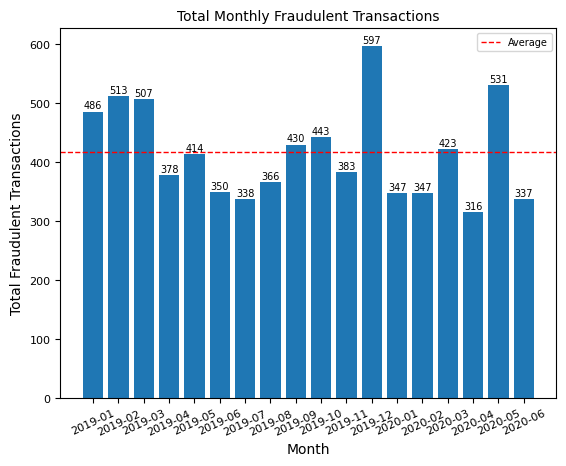

In [496]:
# Create new DataFrame for analysis
df1 = df_clean.select("trans_date_trans_time", "is_fraud")
df1 = df1.filter("is_fraud == True")

# Extract year from date column
df1 = df1.withColumn('month', date_format("trans_date_trans_time", "yyy-MM"))

# Finalise DataFrame
df1 = df1.groupBy("month").count().orderBy("month")

# Convert DataFrame to Pandas DataFrame
df1_final = df1.toPandas()

# Create function to add value labels
x = df1_final["month"]
y = df1_final["count"]
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i] + 5, y[i], ha = 'center', fontsize = 7)

# Visualise data
plt.bar(x, y)
plt.axhline(y = np.mean(y), color = 'red', linestyle = '--', linewidth = 1, label = 'Average')
plt.legend(loc = 'upper right', fontsize = 7) 
plt.title("Total Monthly Fraudulent Transactions", fontsize = 10)
plt.xlabel("Month", fontsize = 10)
plt.ylabel("Total Fraudulent Transactions", fontsize = 10)
addlabels(x, y)
plt.xticks(rotation = 25, fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

##### Monthly Fraudulent Sum

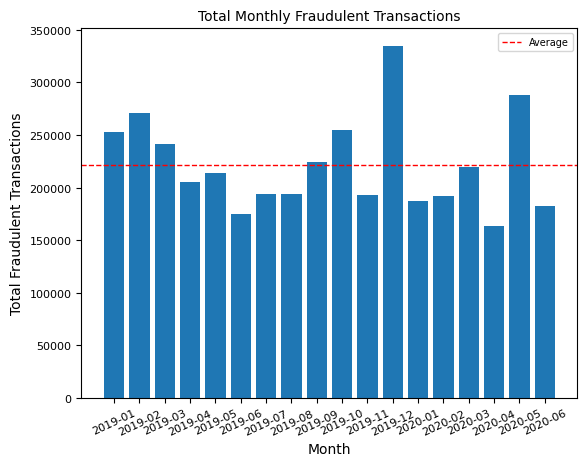

+-------+---------+
|  month|      sum|
+-------+---------+
|2019-01|252961.88|
|2019-02|270698.78|
|2019-03|241292.31|
|2019-04|205443.45|
|2019-05|213820.23|
|2019-06|175054.29|
|2019-07| 193720.7|
|2019-08|193898.41|
|2019-09|224728.84|
|2019-10|254857.96|
|2019-11|193402.11|
|2019-12|334583.59|
|2020-01|187383.15|
|2020-02|192522.64|
|2020-03|219170.44|
|2020-04|163107.05|
|2020-05|288438.71|
|2020-06|183004.07|
+-------+---------+



In [497]:
# Create new DataFrame for analysis
df2 = df_clean.select("amt", "trans_date_trans_time", "is_fraud")
df2 = df2.filter("is_fraud == True")

# Extract year from date column
df2 = df2.withColumn('month', date_format("trans_date_trans_time", "yyy-MM"))

# Finalise DataFrame
df2 = df2.groupBy("month").sum("amt").orderBy("month")
df2 = df2.withColumnRenamed("sum(amt)", "sum")
df2 = df2.withColumn("sum", round("sum", 2))

# Convert DataFrame to Pandas DataFrame
df2_final = df2.toPandas()

# Visualise data
x = df2_final["month"]
y = df2_final["sum"]

plt.bar(x, y)
plt.axhline(y = np.mean(y), color = 'red', linestyle = '--', linewidth = 1, label = 'Average')
plt.legend(loc = 'upper right', fontsize = 7) 
plt.title("Total Monthly Fraudulent Transactions", fontsize = 10)
plt.xlabel("Month", fontsize = 10)
plt.ylabel("Total Fraudulent Transactions", fontsize = 10)
plt.xticks(rotation = 25, fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

df2.show()

##### Top 10 User Cities With Highest Fraudulent Transactions

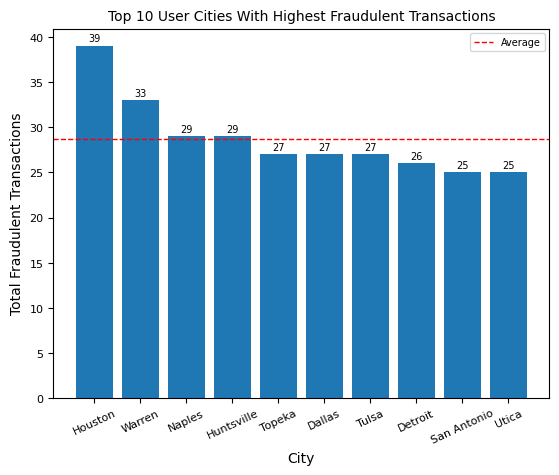

In [498]:
# Create new DataFrame for analysis
df3 = df_clean.select("city", "is_fraud")
df3 = df3.filter("is_fraud == True")

# Finalise DataFrame
df3 = df3.groupBy("city").count().orderBy("count", ascending=False)
df3 = df3.limit(10)

# Convert DataFrame to Pandas DataFrame
df3_final = df3.toPandas()

# Create function to add value labels
x = df3_final["city"]
y = df3_final["count"]
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.5, y[i], ha = 'center', fontsize = 7)

# Visualise data
plt.bar(x, y)
plt.axhline(y = np.mean(y), color = 'red', linestyle = '--', linewidth = 1, label = 'Average')
plt.legend(loc = 'upper right', fontsize = 7) 
plt.title("Top 10 User Cities With Highest Fraudulent Transactions", fontsize = 10)
plt.xlabel("City", fontsize = 10)
plt.ylabel("Total Fraudulent Transactions", fontsize = 10)
addlabels(x, y)
plt.xticks(rotation = 25, fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()